In [1]:
from IPython.core.display import HTML
with open ("../../style.css", "r") as file:
    css = file.read()
HTML(css)

# An Interpreter for a Simple Programming Language

In this notebook we develop an interpreter for a small programming language.
The grammar for this language is stored in the file `Pure.g4`.

In [2]:
!cat -n Pure.g4

     1	grammar Pure;
     2	
     3	program  : statement+
     4	         ;
     5	
     6	statement: VAR ':=' expr ';'
     7	         | VAR ':=' 'read' '(' ')' ';'
     8	         | 'print' '(' expr ')' ';'
     9	         | 'if'    '(' boolExpr ')' '{' statement* '}'
    10	         | 'while' '(' boolExpr ')' '{' statement* '}'
    11	         ;
    12	
    13	boolExpr : expr '==' expr
    14	         | expr '<'  expr
    15	         ;
    16	
    17	expr     : expr '+' product
    18	         | expr '-' product
    19	         | product
    20	         ;
    21	
    22	product  : product '*' factor
    23	         | product '/' factor
    24	         | factor
    25	         ;
    26	
    27	factor   : '(' expr ')'
    28	         | VAR
    29	         | NUMBER
    30	         ;
    31	
    32	VAR      : [a-zA-Z][a-zA-Z_0-9]*;
    33	NUMBER   : '0'|[1-9][0-9]*;
    34	
    35	MULTI_COMMENT : '/*' .*? '*/' -> skip;
    36	LINE_COMMENT  : '//' ~('\n')* -> skip;
    37	WS            :

The grammar shown above does only contain `skip` actions.  The corrsponding grammar that is enriched with actions is stored in the file `Simple.g4`.

An example program that conforms to this grammar is stored in the file `sum.sl`.

In [3]:
!cat sum.sl

n := read();
s := 0;
i := 0;
while (i < n * n) {
    i := i + 1;
    s := s + i;
}
print(s);


The file `Simple.g4` contains a parser for the language described by the grammar `Pure.g4`. This parser returns
an abstract syntax tree.  This tree is represented as a *nested tuple*.

In [4]:
!cat -n Simple.g4

     1	grammar Simple;
     2	
     3	program returns [stmnt_list] 
     4	    : {SL = ['program']} (s = statement {SL.append($s.stmnt)})+ {$stmnt_list = tuple(SL)}
     5	    ;
     6	
     7	statement returns [stmnt]
     8	    : v = VAR ':=' e = expr ';'       {$stmnt = (':=', $v.text, $e.result)}
     9	    | v = VAR ':=' 'read' '(' ')' ';' {$stmnt = ('read', $v.text)}
    10	    | 'print' '(' r = expr ')' ';'    {$stmnt = ('print', $r.result)}
    11	    | 'if' '(' b = boolExpr ')' {SL = []} '{' (l = statement {SL.append($l.stmnt) })* '}' 
    12	      {$stmnt = ('if', $b.result) + tuple(SL)}
    13	    | 'while' '(' b = boolExpr ')' {SL = []} '{' (l = statement {SL.append($l.stmnt) })* '}' 
    14	      {$stmnt = ('while', $b.result) + tuple(SL)}
    15	    ;
    16	
    17	boolExpr returns [result]
    18	    : l = expr '==' r = expr {$result = ('==', $l.result, $r.result)} 
    19	    | l = expr '<'  r = expr {$result = ('<',  $l.result, $r.result)}
    20	    ;
    21	
    22	

The parser shown above will transform the program `sum.sl` into the *nested tuple* stored in the file `sum.ast`.

In [5]:
!cat sum.ast

('program',
    ('read', 'n'),
    (':=', 's', 0),
    (':=', 'i', 0),
    ('while',
 	('<',  'i', ('*', 'n', 'n')),
     	(':=', 'i', ('+', 'i', 1)),
 	(':=', 's', ('+', 's', 'i'))
    ),
 ('print', 's')
)

In [6]:
!antlr4 -Dlanguage=Python3 Simple.g4

In [7]:
from SimpleLexer  import SimpleLexer
from SimpleParser import SimpleParser
import antlr4

In [8]:
%run ../AST-2-Dot.ipynb

The function `main` takes one parameter `file`.  This parameter is a string specifying a program file.  
The function reads the program contained in this file and executes it.

In [9]:
def main(file):
    with open(file, 'r') as handle:
        program_text = handle.read()
    input_stream  = antlr4.InputStream(program_text)
    lexer         = SimpleLexer(input_stream)
    token_stream  = antlr4.CommonTokenStream(lexer)
    parser        = SimpleParser(token_stream)
    result        = parser.program()
    Statements    = result.stmnt_list
    ast           = tuple2dot(Statements)
    print(Statements)
    display(ast)
    ast.render('ast', view=True)
    execute_tuple(Statements)

The function `execute_list` takes two arguments:
- `Statement_List` is a list of statements,
- `Values` is a dictionary assigning integer values to variable names.

The function executes the statements in `Statement_List`.  If an assignment statement is executed,
the dictionary `Values` is updated.

In [10]:
def execute_tuple(Statement_List, Values={}):
    for stmnt in Statement_List:
        execute(stmnt, Values)

The function `execute` takes two arguments:
- `stmnt` is a statement,
- `Values` is a dictionary assigning integer values to variable names.

The function executes the statements in `Statement_List`.  If an assignment statement is executed,
the dictionary `Values` is updated.

In [11]:
def execute(stmnt, Values):
    op = stmnt[0]
    if stmnt == 'program':
        pass
    elif op == ':=':
        _, var, value = stmnt
        Values[var] = evaluate(value, Values)
    elif op == 'read':
        _, var = stmnt
        Values[var] = int(input())
    elif op == 'print':
        _, expr = stmnt
        print(evaluate(expr, Values))
    elif op == 'if':
        _, test, *SL = stmnt
        if evaluate(test, Values):
            execute_tuple(SL, Values)
    elif op == 'while':
        _, test, *SL = stmnt
        while evaluate(test, Values):
            execute_tuple(SL, Values)
    else:
        assert False, f'{stmnt} unexpected'

The function `evaluate` takes two arguments:
- `expr` is a logical expression or an arithmetic expression,
- `Values` is a dictionary assigning integer values to variable names.

The function evaluates the given expression and returns this value.

In [12]:
def evaluate(expr, Values):
    if isinstance(expr, int):
        return expr
    if isinstance(expr, str):
        return Values[expr] 
    op = expr[0]
    if op == '==':
        _, lhs, rhs = expr
        return evaluate(lhs, Values) == evaluate(rhs, Values)
    if op == '<':
        _, lhs, rhs = expr
        return evaluate(lhs, Values) < evaluate(rhs, Values)
    if op == '+':
        _, lhs, rhs = expr
        return evaluate(lhs, Values) + evaluate(rhs, Values)
    if op == '-':
        _, lhs, rhs = expr
        return evaluate(lhs, Values) - evaluate(rhs, Values)
    if op == '*':
        _, lhs, rhs = expr
        return evaluate(lhs, Values) * evaluate(rhs, Values)
    if op == '/':
        _, lhs, rhs = expr
        return evaluate(lhs, Values) / evaluate(rhs, Values)
    assert False, f'{stmnt} unexpected'

In [13]:
!cat sum.sl

n := read();
s := 0;
i := 0;
while (i < n * n) {
    i := i + 1;
    s := s + i;
}
print(s);


('program', ('read', 'n'), (':=', 's', 0), (':=', 'i', 0), ('while', ('<', 'i', ('*', 'n', 'n')), (':=', 'i', ('+', 'i', 1)), (':=', 's', ('+', 's', 'i'))), ('print', 's'))


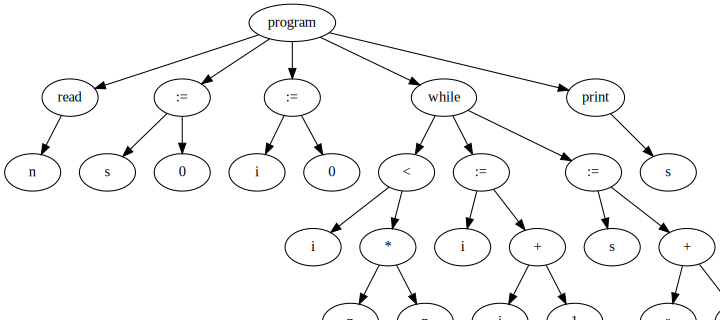

7
1225


In [14]:
main('sum.sl')

In [15]:
!cat factorial.sl

f := 1;
i := 0;
while (i < 10) {
    i := i + 1;
    f := i * f;
}
print(f);



('program', (':=', 'f', 1), (':=', 'i', 0), ('while', ('<', 'i', 10), (':=', 'i', ('+', 'i', 1)), (':=', 'f', ('*', 'i', 'f'))), ('print', 'f'))


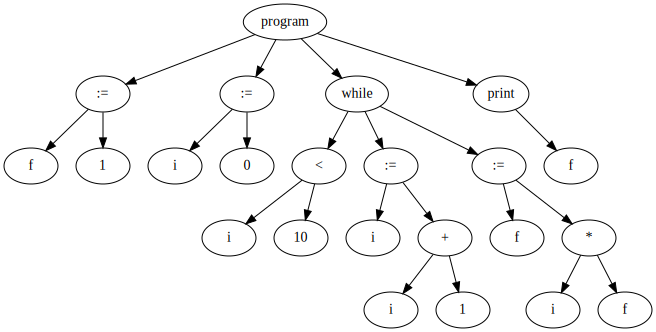

3628800


In [16]:
main('factorial.sl')

In [17]:
!rm *.py *.tokens *.interp
!rm -r __pycache__/
!rm *.pdf

In [18]:
!ls

Interpreter.ipynb Simple.g4         factorial.sl      sum.sl
Pure.g4           ast               sum.ast
